In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
import os
import sys
sys.path.append( os.path.abspath("../../workspace/python-work/python 3/cs230_deeplearning_implement/ec_code/")  )
from class2.week2.assignment2.opt_utils import * 
from class2.week2.assignment2.testCases import * 
'''
 1. 分割数据集 
  2. 优化梯度下降算法： 
     2.1 不使用任何优化算法 
     2.2 mini-batch梯度下降法 
     2.3 使用具有动量的梯度下降算法 gradient descent with momentum
     2.4 使用Adam算法
'''
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [11]:
#mini-batch梯度下降法 

# GRADED FUNCTION: update_parameters_with_gd
def update_parameters_with_gd(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l +1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l +1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters



# GRADED FUNCTION: random_mini_batches
def mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    np.random.seed(seed)   # To make your "random" minibatches the same as ours
    m = X.shape[1]         # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)  打乱顺序
    #它会返回一个长度为m的随机数组，且里面的数是0到m-1
    permutation = list(np.random.permutation(m))   
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    """
    理解看一下下面的伪代码，看看X和Y是如何根据permutation来打乱顺序的。
    x = np.array([[1,2,3,4,5,6,7,8,9],
                  [9,8,7,6,5,4,3,2,1]])
    y = np.array([[1,0,1,0,1,0,1,0,1]])

    random_mini_batches(x,y)
    permutation= [7, 2, 1, 4, 8, 6, 3, 0, 5]
    shuffled_X= [[8 3 2 5 9 7 4 1 6]
                 [2 7 8 5 1 3 6 9 4]]
    shuffled_Y= [[0 1 0 1 1 1 0 1 0]]
    """
    
    # Step 2: Partition分割 (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:,mini_batch_size * num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:,mini_batch_size * num_complete_minibatches:]

        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches




In [12]:
# 使用具有动量的梯度下降算法 gradient descent with momentum

# GRADED FUNCTION: initialize_velocity  
def initialize_velocity(parameters):
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    # Initialize velocity   相当于v0=0  初速度
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return v



# GRADED FUNCTION: update_parameters_with_momentum
#  v_dW=β*v_dW+(1−β)*dW     W=W−α*v_dW
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Arguments:
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """
    L = len(parameters) // 2    # number of layers in the neural networks
    # Momentum update for each parameter
    #  v_dW=β*v_dW+(1−β)*dW     W=W−α*v_dW
    for l in range(L):
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]
        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
        
    return parameters, v





In [13]:
"""
Adam算法是训练神经网络中最有效的算法之一，它是RMSProp算法与Momentum算法的结合体。
t ：当前迭代的次数
l：当前神经网络的层数
β1 和 β2： 控制两个指数加权平均值的超参数
α ：学习率
ε：一个非常小的数，用于避免除零操作，一般为10**(-8)
"""

# GRADED FUNCTION: initialize_adam
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    return v, s


# GRADED FUNCTION: update_parameters_with_adam
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    #t表示迭代次数   v  s是上一次的v  s
    L = len(parameters) // 2      # number of layers in the neural networks
    v_corrected = {}            # Initializing first moment estimate, python dictionary
    s_corrected = {}        # Initializing second moment estimate, python dictionary
    # Perform Adam update on all parameters
    for l in range(L):
        #梯度的移动平均值,输入："v , grads , beta1",输出：" v "
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        #计算第一阶段的偏差修正后的估计值，输入"v , beta1 , t" , 输出："v_corrected"
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))
        #计算平方梯度的移动平均值，输入："s, grads , beta2"，输出："s"
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])
        #计算第二阶段的偏差修正后的估计值，输入："s , beta2 , t"，输出："s_corrected"
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))
        
        #更新参数，输入: "parameters, learning_rate, v_corrected, s_corrected, epsilon". 输出: "parameters".
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon))
        
    return parameters, v, s




In [14]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 10000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    Arguments: 
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0  #  initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass   #   不使用任何优化器，直接使用梯度下降法
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost = compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1    # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # Print the cost every 1000 epoch
        if i % 100 == 0:
            costs.append(cost)
            if print_cost and i % 1000 == 0:
                print ("Cost after epoch %i: %f" %(i, cost))
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters





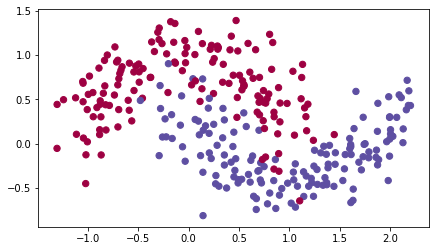

In [16]:
train_X, train_Y = load_dataset()

Cost after epoch 0: 0.690736


Cost after epoch 1000: 0.685273


Cost after epoch 2000: 0.647072


Cost after epoch 3000: 0.619525


Cost after epoch 4000: 0.576584


Cost after epoch 5000: 0.607243


Cost after epoch 6000: 0.529403


Cost after epoch 7000: 0.460768


Cost after epoch 8000: 0.465586


Cost after epoch 9000: 0.464518


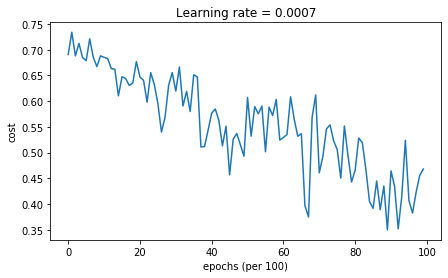

Accuracy: 0.7966666666666666


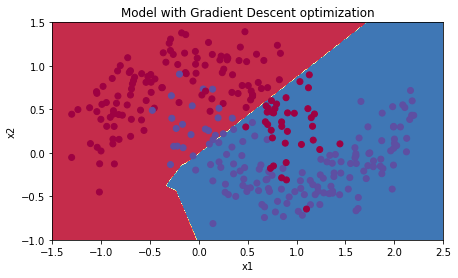

In [20]:
#gradient descent
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")


# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.690741


Cost after epoch 1000: 0.685341


Cost after epoch 2000: 0.647145


Cost after epoch 3000: 0.619594


Cost after epoch 4000: 0.576665


Cost after epoch 5000: 0.607324


Cost after epoch 6000: 0.529476


Cost after epoch 7000: 0.460936


Cost after epoch 8000: 0.465780


Cost after epoch 9000: 0.464740


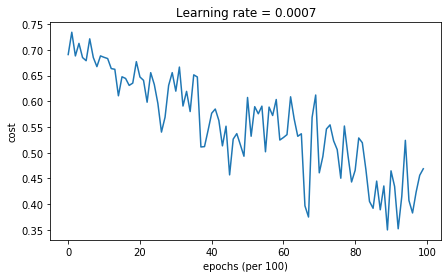

Accuracy: 0.7966666666666666


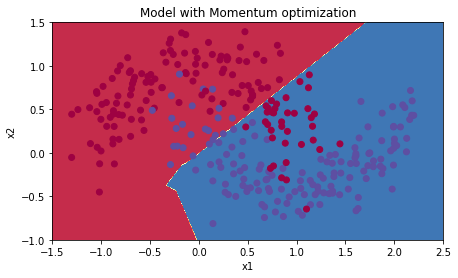

In [21]:
# momentum descent
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after epoch 0: 0.690552


Cost after epoch 1000: 0.185501


Cost after epoch 2000: 0.150830


Cost after epoch 3000: 0.074454


Cost after epoch 4000: 0.125959


Cost after epoch 5000: 0.104344


Cost after epoch 6000: 0.100676


Cost after epoch 7000: 0.031652


Cost after epoch 8000: 0.111973


Cost after epoch 9000: 0.197940


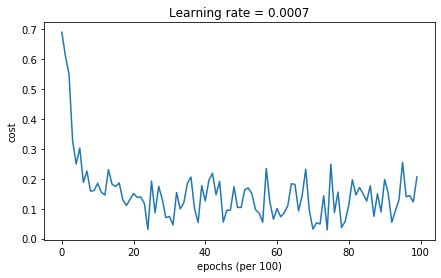

Accuracy: 0.94


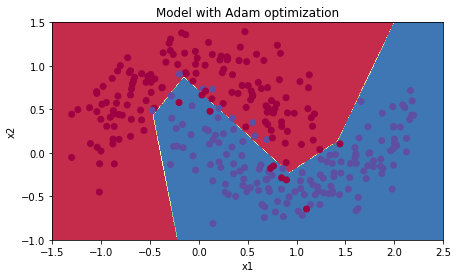

In [22]:
# adam descent
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)
# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
"""
总结
优化算法            准确度	    曲线平滑度
梯度下降	            79.7%	    震荡
momentum梯度下降算法	79.7%   	震荡
Adam优化后的梯度下降	 94%	    平滑
 
具有动量的梯度下降通常可以有很好的效果，但由于小的学习速率和简单的数据集所以它的影响几乎是轻微的。
另一方面，Adam明显优于小批量梯度下降和具有动量的梯度下降，如果在这个简单的模型上运行更多时间的数据集，这三种方法都会产生非常好的结果，然而，我们已经看到Adam收敛得更快。

Adam的一些优点包括相对较低的内存要求（虽然比梯度下降和动量下降更高）和通常运作良好，即使对参数进行微调（除了学习率αα）

"""